Hay que programar una funcion donde se guarden las metricas y la sepocas en un txt. Ya que si quiero seguir entrenando el modelo, puedo seguir agregando las metricas nuevas a continuación de las anteriores.

In [45]:
import os, time, json
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from src.ic import *
from src.bc import *
from src.domain import *

In [46]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Usando MPS (Apple GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Usando CUDA (NVIDIA GPU)")
else:
    device = torch.device("cpu")
    print("Usando CPU")

Usando MPS (Apple GPU)


In [47]:
ROOT = os.getcwd()
MODELS_PATH = os.path.join(ROOT, "models")
DATA_PATH = os.path.join(ROOT, "data")
FIGURES_PATH = os.path.join(ROOT, "figures")
METRICS_PATH = os.path.join(ROOT, "metrics")

In [48]:
class PINN(nn.Module):
    def __init__(
            self, 
            sizes: list, 
            activations: list,
            loss_fn = nn.MSELoss(),  
            init_type: str='xavier', 
            device: str='cpu',
            dropout: float=0.2,
    ):
        super(PINN, self).__init__()
        self.sizes = sizes
        self.num_layers = len(sizes)
        self.loss_fn = loss_fn
        self.dropout = dropout
        self.device = device
        self.lambda_ic = 1.0
        self.lambda_bc = 1.0
        self.lambda_domain = 1.0
        
        # Define the layers.
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
            if i < len(activations):
                layers.append(activations[i])
            if dropout > 0.0:
                layers.append(nn.Dropout(dropout))
        self.layers = nn.Sequential(*layers)

        # Initialize the parameters.
        if init_type is not None:
            self.initializeWeights(init_type)

        # Define the metrics.
        self.metrics = {
            'epochs': [], 
            'loss': {
                'train': {'ic': [], 'bc': [], 'domain': [], 'total': []}, 
                'val'  : {'ic': [], 'bc': [], 'domain': [], 'total': []},
                'test' : {'ic': None, 'bc': None, 'domain': None, 'total': None}
            }, 
            'time': 0.0
        }

    def fit(self, train_dataloader, optimizer=optim.Adam, epochs=30, lr=1e-4, 
        regularization=0.0, val_dataloader=None, verbose=True, epoch_print=1,
        weighted_loss: bool=False, alpha: float=0.9, epoch_refresh: int=10):

        # Set the starting epoch
        last_epoch = self.metrics['epochs'][-1] if self.metrics['epochs'] else 0
        starting_epoch = last_epoch + 1
    
        # Get the dataloaders
        ic_train_dl, left_train_dl, right_train_dl, domain_train_dl = train_dataloader
        ic_val_dl, left_val_dl, right_val_dl, domain_val_dl = val_dataloader
        optimizer = optimizer(self.parameters(), lr=lr, weight_decay=regularization)

        # Start the training
        start_time = time.time()
        for i in range(epochs):
            # Train the model
            self.train()
            train_loss_ic, train_loss_bc, train_loss_domain, train_loss = 0.0, 0.0, 0.0, 0.0
            for ic_batch, left_batch, right_batch, domain_batch in zip(
                ic_train_dl, left_train_dl, right_train_dl, domain_train_dl):
                self.trainBatch(ic_batch, left_batch, right_batch, domain_batch, optimizer)
            
            # Evaluate the model
            self.eval()
            self.metrics['epochs'].append(starting_epoch + i)
            train_loss = self.computeLoss(ic_train_dl, left_train_dl, right_train_dl, domain_train_dl)
            self.metrics['loss']['train']['ic'].append(train_loss[0].item())
            self.metrics['loss']['train']['bc'].append(train_loss[1].item())
            self.metrics['loss']['train']['domain'].append(train_loss[2].item())
            self.metrics['loss']['train']['total'].append(train_loss[3].item())
            if val_dataloader:
                val_loss = self.computeLoss(ic_val_dl, left_val_dl, right_val_dl, domain_val_dl)
                self.metrics['loss']['val']['ic'].append(val_loss[0].item())
                self.metrics['loss']['val']['bc'].append(val_loss[1].item())
                self.metrics['loss']['val']['domain'].append(val_loss[2].item())
                self.metrics['loss']['val']['total'].append(val_loss[3].item())
            
            # Refresh lambda
            if weighted_loss and (i + 1) % epoch_refresh == 0:
                self.train()
                lambda_loss = self.evalLoss(ic_train_dl, left_train_dl, right_train_dl, domain_train_dl)
                self.refreshLambda(lambda_loss[0], lambda_loss[1], lambda_loss[2], optimizer, alpha)
            
            # Print the progress
            if verbose and (i + 1) % epoch_print == 0:
                val_loss = val_loss[3].item() if val_dataloader else 'N/A'
                text = f"Epoch {starting_epoch + i}/{starting_epoch + epochs}: "
                text += f"Loss ({train_loss[3].item():.4g}, {val_loss:.4g})"
                print(text)

        self.metrics['time'] += time.time() - start_time
    
    def forward(self, tx):
        return self.layers(tx)
    
    def predict(self, tx):
        self.eval()
        with torch.no_grad():
            return self.forward(tx)
    
    def initializeWeights(self, init_type):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                if init_type == 'xavier':
                    nn.init.xavier_uniform_(layer.weight)
                elif init_type == 'he':
                    nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                elif init_type == 'normal':
                    nn.init.normal_(layer.weight, mean=0, std=0.01)
                if layer.bias is not None:
                    nn.init.uniform_(layer.bias, a=0, b=1)
    
    def initializeLambda(self, ic: float=1.0, bc: float=1.0, domain: float=1.0):
        self.lambda_ic = ic
        self.lambda_bc = bc
        self.lambda_domain = domain

    def refreshLambda(self, loss_ic: float, loss_bc: float, loss_domain: float, optimizer: optim.Optimizer, alpha: float=0.9):
        # Compute gradient norm of the parameters 
        ## due to the initial condition loss
        optimizer.zero_grad()
        loss_ic.backward(retain_graph=True)
        params_grad_norm_ic = self.computeParamsGradNorm()
        ## due to the boundary condition loss
        optimizer.zero_grad()
        loss_bc.backward(retain_graph=True)
        params_grad_norm_bc = self.computeParamsGradNorm()
        ## due to the domain loss
        optimizer.zero_grad()
        loss_domain.backward(retain_graph=True)
        params_grad_norm_domain = self.computeParamsGradNorm()

        # Compute new lambdas
        total_grad_norm = params_grad_norm_ic + params_grad_norm_bc + params_grad_norm_domain
        new_lambda_ic = total_grad_norm / params_grad_norm_ic
        new_lambda_bc = total_grad_norm / params_grad_norm_bc
        new_lambda_domain = total_grad_norm / params_grad_norm_domain

        # Update lambda
        self.lambda_ic = alpha * self.lambda_ic + (1 - alpha) * new_lambda_ic.item()
        self.lambda_bc = alpha * self.lambda_bc + (1 - alpha) * new_lambda_bc.item()
        self.lambda_domain = alpha * self.lambda_domain + (1 - alpha) * new_lambda_domain.item()

    def evalLoss(self, ic_dl, left_dl, right_dl, domain_dl):
        # Compute size of dataloaders
        n_ic = torch.tensor(len(ic_dl), device=self.device)
        n_bc = torch.tensor(len(left_dl), device=self.device)
        n_dom = torch.tensor(len(domain_dl), device=self.device)
        
        # Compute initial condition loss
        ic_loss = torch.tensor(0.0, device=self.device)
        for tx_batch, eta_batch in ic_dl:
            n_batch = torch.tensor(tx_batch.shape[0], device=self.device)
            loss_batch = self.computeSupervisedLoss(tx_batch, eta_batch)
            ic_loss += loss_batch * n_batch
        ic_loss /= n_ic
        
        # Compute bc loss
        bc_loss = torch.tensor(0.0, device=self.device)
        for left_batch, right_batch in zip(left_dl, right_dl):
            n_batch = torch.tensor(left_batch.shape[0], device=self.device)
            loss_batch = self.computeBCsLoss(left_batch, right_batch)
            bc_loss += loss_batch * n_batch
        bc_loss /= n_bc
        
        # Compute domain loss
        domain_loss = torch.tensor(0.0, device=self.device)
        for tx_batch in domain_dl:
            n_batch = torch.tensor(tx_batch.shape[0], device=self.device)
            loss_batch = self.computePDELoss(tx_batch)
            domain_loss += loss_batch * n_batch
        domain_loss /= n_dom

        # Compute total loss
        lambda_ic = torch.tensor(self.lambda_ic, device=self.device)
        lambda_bc = torch.tensor(self.lambda_bc, device=self.device)
        lambda_domain = torch.tensor(self.lambda_domain, device=self.device)
        total_loss = ic_loss * lambda_ic
        total_loss += bc_loss * lambda_bc
        total_loss += domain_loss * lambda_domain
        
        return ic_loss, bc_loss, domain_loss, total_loss
    
    def computeLoss(self, ic_dl, left_dl, right_dl, domain_dl):
        # Compute initial condition loss
        ic_loss = 0.0
        for tx_batch, eta_batch in ic_dl:
            loss_batch = self.computeSupervisedLoss(tx_batch, eta_batch)
            ic_loss += loss_batch * tx_batch.shape[0]
        ic_loss /= len(ic_dl)

        # Compute bc loss
        bc_loss = 0.0
        for left_batch, right_batch in zip(left_dl, right_dl):
            loss_batch = self.computeBCsLoss(left_batch, right_batch)
            bc_loss += loss_batch * left_batch.shape[0]
        bc_loss /= len(left_dl)

        # Compute domain loss
        domain_loss = 0.0
        for tx_batch in domain_dl:
            loss_batch = self.computePDELoss(tx_batch)
            domain_loss += loss_batch * tx_batch.shape[0]
        domain_loss /= len(domain_dl)

        # Compute total loss
        total_loss = ic_loss * self.lambda_ic
        total_loss += bc_loss * self.lambda_bc
        total_loss += domain_loss * self.lambda_domain
        
        return ic_loss, bc_loss, domain_loss, total_loss
    
    def computeSupervisedLoss(self, input_batch, target_batch, gradient: bool=False, axis: int=0):
        prediction_batch = self.forward(input_batch)
        if gradient:
            grad_batch = torch.autograd.grad(prediction_batch, input_batch, torch.ones_like(prediction_batch))[0]
            grad_batch = grad_batch[:, axis:axis+1] # Get the gradient in the specified axis
            loss = self.loss_fn(grad_batch, target_batch)
        else:
            loss = self.loss_fn(prediction_batch, target_batch)
        return loss
    
    def computeBCsLoss(self, tx_left_batch, tx_right_batch):
        eta_left = self.forward(tx_left_batch)
        eta_right = self.forward(tx_right_batch)

        # Compute 1st order derivatives
        eta_left_tx = torch.autograd.grad(eta_left, tx_left_batch, torch.ones_like(eta_left), create_graph=True)[0]
        eta_right_tx = torch.autograd.grad(eta_right, tx_right_batch, torch.ones_like(eta_right), create_graph=True)[0]
        eta_left_t = eta_left_tx[:, 0:1]
        eta_left_x = eta_left_tx[:, 1:2]
        eta_right_t = eta_right_tx[:, 0:1]
        eta_right_x = eta_right_tx[:, 1:2]

        # Compute the boundary loss
        loss = self.loss_fn(eta_left_t, eta_left_x)
        loss += self.loss_fn(eta_right_t, -1 * eta_right_x)
        return loss
    
    def computePDELoss(self, tx_batch):
        eta = self.forward(tx_batch)
        eta2 = eta ** 2
        eta_tx = torch.autograd.grad(eta, tx_batch, torch.ones_like(eta), create_graph=True)[0]
        eta_t, eta_x = eta_tx[:, 0:1], eta_tx[:, 1:2]
        eta_tt = torch.autograd.grad(eta_t, tx_batch, torch.ones_like(eta_t), create_graph=True)[0][:, 0:1]
        eta_xx = torch.autograd.grad(eta_x, tx_batch, torch.ones_like(eta_x), create_graph=True)[0][:, 1:2]

        aux = 3 * eta2 + eta_xx
        aux_tx = torch.autograd.grad(aux, tx_batch, torch.ones_like(aux), create_graph=True)[0]
        aux_x = aux_tx[:, 1:2]
        aux_xx = torch.autograd.grad(aux_x, tx_batch, torch.ones_like(aux_x), create_graph=True)[0][:, 1:2]

        f = eta_tt - eta_xx - aux_xx                    # compute residual
        return self.loss_fn(f, torch.zeros_like(f))     # compute loss
    
    def computeParamsNorm(self):
        return torch.sqrt(sum(p.norm() ** 2 for p in self.parameters() if p.requires_grad))
    
    def computeParamsGradNorm(self):
        return torch.sqrt(sum(p.grad.norm() ** 2 for p in self.parameters() if p.requires_grad and p.grad is not None))
    
    def trainBatch(self, ic_batch, left_batch, right_batch, domain_batch, optimizer):
        ic_tx, ic_eta = ic_batch
        loss_ic = self.computeSupervisedLoss(ic_tx, ic_eta)
        loss_bc = self.computeBCsLoss(left_batch, right_batch)
        loss_domain = self.computePDELoss(domain_batch)
        loss = loss_ic * self.lambda_ic 
        loss += loss_bc * self.lambda_bc 
        loss += loss_domain * self.lambda_domain
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        return loss_ic.item(), loss_bc.item(), loss_domain.item(), loss.item()
    
    def size(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def save(self, model_path: str="model_params.pth", metrics_path: str="metrics.txt"):
        torch.save(self.state_dict(), model_path)
        with open(metrics_path, 'w') as f:
            f.truncate()
            json.dump(self.metrics, f)
        f.close()

    def load(self, model_path: str="model_params.pth", metrics_path: str="metrics.txt"):
        self.load_state_dict(torch.load(model_path, weights_only=True))
        with open(metrics_path, 'r') as f:
            self.metrics = json.load(f)
        f.close()
        self.to(self.device)

    def plotLoss(self, figsize=(10, 5), save: bool=False, filename: str="loss.png", log_x: bool=False):
        # Plot 4 subplots: train and val loss for ic, bc, domain and total (2 x 2)
        fig, axs = plt.subplots(2, 2, figsize=figsize)
        # Plot ic loss
        axs[0, 0].plot(self.metrics['epochs'], self.metrics['loss']['train']['ic'], label='Train')
        axs[0, 0].plot(self.metrics['epochs'], self.metrics['loss']['val']['ic'], label='Val')
        axs[0, 0].set_title('IC')
        # Plot bc loss
        axs[0, 1].plot(self.metrics['epochs'], self.metrics['loss']['train']['bc'], label='Train')
        axs[0, 1].plot(self.metrics['epochs'], self.metrics['loss']['val']['bc'], label='Val')
        axs[0, 1].set_title('BC')
        # Plot domain loss
        axs[1, 0].plot(self.metrics['epochs'], self.metrics['loss']['train']['domain'], label='Train')
        axs[1, 0].plot(self.metrics['epochs'], self.metrics['loss']['val']['domain'], label='Val')
        axs[1, 0].set_title('Domain')
        # Plot total loss
        axs[1, 1].plot(self.metrics['epochs'], self.metrics['loss']['train']['total'], label='Train')
        axs[1, 1].plot(self.metrics['epochs'], self.metrics['loss']['val']['total'], label='Val')
        axs[1, 1].set_title('Total')
        # Set axes properties
        for ax in axs.flatten():
            ax.set_yscale('log')
            ax.set_xlabel('Epochs')
            ax.set_ylabel('Loss')
            ax.legend(loc='best')
            ax.grid(True, which='both', ls='--', alpha=0.5, c='gray')
        if log_x:
            for ax in axs.flatten():
                ax.set_xscale('log')
        # Save the figure
        plt.tight_layout()
        if save:
            plt.savefig(filename, dpi=300, facecolor='w', edgecolor='w')
        plt.show()

In [49]:
ic_dl = getICDataLoader(n=200, batch_size=32)
bc_left_dl, bc_right_dl = getBCDataLoader(n=200, batch_size=32)
domain_dl = getDomainDataLoader(n=10000, batch_size=128)

train_dl = (ic_dl[0], bc_left_dl[0], bc_right_dl[0], domain_dl[0])
val_dl = (ic_dl[1], bc_left_dl[1], bc_right_dl[1], domain_dl[1])

In [50]:
X_ic = []
for tx_batch, _ in train_dl[0]:
    X_ic.append(tx_batch.detach().cpu().numpy())
X_ic = np.concatenate(X_ic, axis=0)

X_left, X_right = [], []
for left_tx_batch, right_tx_batch in zip(train_dl[1], train_dl[2]):
    X_left.append(left_tx_batch.detach().cpu().numpy())
    X_right.append(right_tx_batch.detach().cpu().numpy())
X_left = np.concatenate(X_left, axis=0)
X_right = np.concatenate(X_right, axis=0)

X_domain = []
for tx_batch in train_dl[3]:
    X_domain.append(tx_batch.detach().cpu().numpy())
X_domain = np.concatenate(X_domain, axis=0)

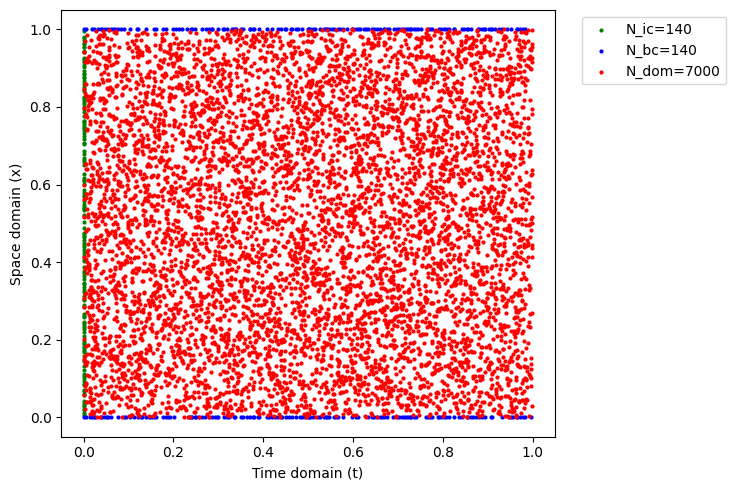

In [51]:
# Plot the locations of the collocation points in the space-time domain
fig = plt.figure(figsize=(7.5, 5))
ax = fig.add_subplot(111)
ax.scatter(X_ic[:, 0:1], X_ic[:, 1:2], s=4, c='g', label=f'N_ic={X_ic.shape[0]}')
ax.scatter(X_left[:, 0:1], X_left[:, 1:2], s=4, c='b', label=f'N_bc={X_left.shape[0]}')
ax.scatter(X_right[:, 0:1], X_right[:, 1:2], s=4, c='b')
ax.scatter(X_domain[:, 0:1], X_domain[:, 1:2], s=4, c='r', label=f'N_dom={X_domain.shape[0]}')
ax.legend(loc='best')
plt.xlabel('Time domain (t)')
plt.ylabel('Space domain (x)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.savefig(FIGURES_PATH + '/collocation_points.png', dpi=300, facecolor='w', edgecolor='w')
plt.show()

In [52]:
hn, hl = 128, 4
sizes = [2] + [hn] * hl + [1]
activations = [nn.Tanh()] * hl
model_path = os.path.join(MODELS_PATH, 'model.pth')
metrics_path = os.path.join(METRICS_PATH, 'metrics.txt')

model = PINN(sizes, activations, device=device)
model.initializeLambda(ic=10.0, bc=10.0, domain=1.0)
model.to(device)

if os.path.exists(model_path) and os.path.exists(metrics_path):
    model.load(model_path, metrics_path)

Epoch 50/501: Loss (0.3291, 0.3631)
Epoch 100/501: Loss (1.441, 1.498)
Epoch 150/501: Loss (1.376, 1.435)
Epoch 200/501: Loss (0.6383, 0.6557)
Epoch 250/501: Loss (0.2498, 0.251)
Epoch 300/501: Loss (0.03276, 0.03177)
Epoch 350/501: Loss (0.03236, 0.0299)
Epoch 400/501: Loss (0.03027, 0.02806)
Epoch 450/501: Loss (0.1571, 0.1573)
Epoch 500/501: Loss (0.1077, 0.1062)


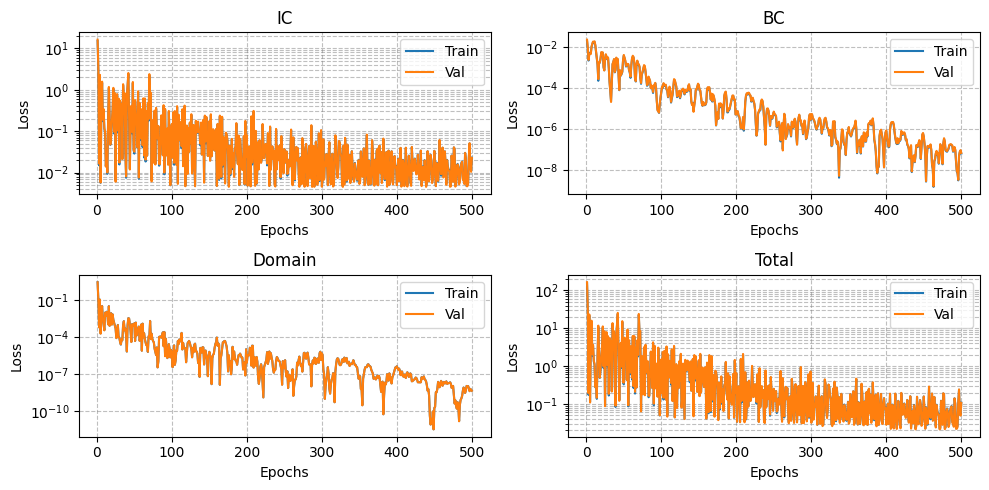

In [53]:
model.fit(train_dataloader=train_dl, 
          optimizer=optim.AdamW, 
          val_dataloader=val_dl, 
          epochs=500, 
          lr=1e-3, 
          regularization=1e-5, 
          epoch_print=50,
          weighted_loss=True,
          alpha=0.8,
          epoch_refresh=100)
model.save(model_path, metrics_path)
model.plotLoss(save=True, filename=FIGURES_PATH + '/loss.png')

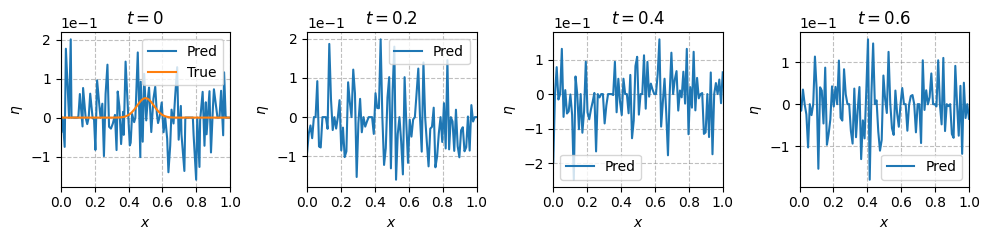

In [54]:
# Plot in 4 subplots (horizontally).
# 1st frame: initial condition (true and predicted)
# 2nd frame: solution at t=0.2
# 3rd frame: solution at t=0.4
# 4th frame: solution at t=0.6

fig, axs = plt.subplots(1, 4, figsize=(10, 2.5))

# t = 0
ic_tx, ic_eta = gaussian(n=100)
idxs = ic_tx[:, 1].argsort()
ic_tx = ic_tx[idxs]
ic_eta = ic_eta[idxs]
ic_tx = torch.tensor(ic_tx, dtype=torch.float32)
ic_eta_pred = model.forward(ic_tx.to(device)).detach().cpu().numpy()
ic_tx = ic_tx.cpu().numpy()
# plot t=0
axs[0].plot(ic_tx[:, 1], ic_eta_pred[:, 0], label='Pred')
axs[0].plot(ic_tx[:, 1], ic_eta[:, 0], label='True')
axs[0].set_title('$t = 0$')

# t = 0.2
x = np.linspace(0, 1, 100).reshape(-1, 1)
t = 0.2 * np.ones_like(x)
tx = np.concatenate((t, x), axis=1)
tx = torch.tensor(tx, dtype=torch.float32)
eta_pred = model.forward(tx.to(device)).detach().cpu().numpy()
tx = tx.cpu().numpy()
# plot t=0.2
axs[1].plot(tx[:, 1], eta_pred[:, 0], label='Pred')
axs[1].set_title('$t = 0.2$')

# t = 0.4
t = 0.4 * np.ones_like(x)
tx = np.concatenate((t, x), axis=1)
tx = torch.tensor(tx, dtype=torch.float32)
eta_pred = model.forward(tx.to(device)).detach().cpu().numpy()
tx = tx.cpu().numpy()
# plot t=0.4
axs[2].plot(tx[:, 1], eta_pred[:, 0], label='Pred')
axs[2].set_title('$t = 0.4$')

# t = 0.6
t = 0.6 * np.ones_like(x)
tx = np.concatenate((t, x), axis=1)
tx = torch.tensor(tx, dtype=torch.float32)
eta_pred = model.forward(tx.to(device)).detach().cpu().numpy()
tx = tx.cpu().numpy()
# plot t=0.6
axs[3].plot(tx[:, 1], eta_pred[:, 0], label='Pred')
axs[3].set_title('$t = 0.6$')

for ax in axs.flatten():
    ax.set_xlim(0, 1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\eta$')
    ax.legend(loc='best')
    # use scientific notation for y axis but always between 0 and 1e-1
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, -1))
    ax.set_xticks(np.arange(0, 1.01, 0.2))
    #ax.set_yticks([5e-2, 4e-2, 2e-2, 1e-2, 0])
    ax.grid(True, which='both', ls='--', alpha=0.5, c='gray')

plt.tight_layout()
plt.savefig(FIGURES_PATH + '/solution.png', dpi=300, facecolor='w', edgecolor='w')
plt.show()


In [55]:
print(f"Lambda: {model.lambda_ic:.4g}, {model.lambda_bc:.4g}, {model.lambda_domain:.4g}")

Lambda: 3.954, 375.7, 2.476e+04
